In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Definir les constantes


In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 
CHANNELS=3
EPOCHS=31

Import data into tensorflow dataset object

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [5]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1000 files belonging to 10 classes.


In [6]:
train_class_names = train_dataset.class_names
valid_class_names=valid_dataset.class_names

In [7]:
train_class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

format des images

In [8]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


visualisation de quelques images du dataset

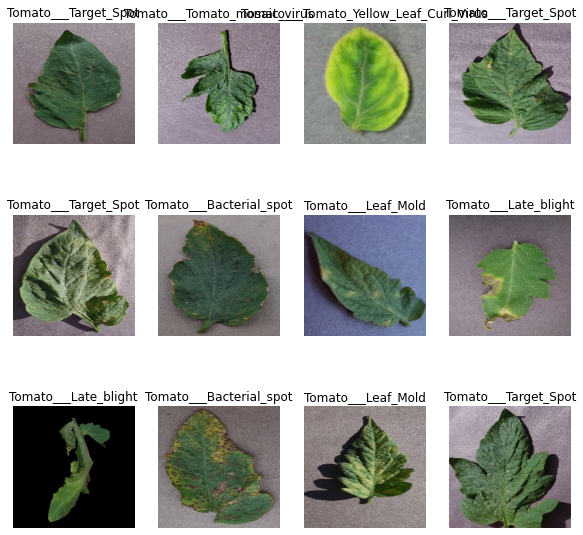

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels_batch[i]])
        plt.axis("off")

Fonction pour partitionner les donnees en donnees entrainement et donnees de test

In [10]:
def get_dataset_partitions_tf(dataset, train_split=0.8, test_split=0.1, shuffle=True, shuffle_size=10000):

    dataset_size = len(dataset)
  
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * dataset_size)
    test_size = dataset_size - train_size

    train_dataset = dataset.take(train_size)    
    test_dataset = dataset.skip(train_size).take(test_size)
    
    return train_dataset, test_dataset

In [11]:
train_ds, test_ds = get_dataset_partitions_tf(train_dataset)

In [12]:
len(train_ds)

250

In [13]:
len(test_ds)

63

In [14]:
len(valid_dataset)

32


Cache, Shuffle, and Prefetch the Dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = valid_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing and normalization 


In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

**Compiling the Model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=31,
)

Epoch 1/31
250/250 [==============================] - 757s 3s/step - loss: 1.8357 - accuracy: 0.3051 - val_loss: 1.4095 - val_accuracy: 0.4830
Epoch 2/31
250/250 [==============================] - 675s 3s/step - loss: 1.1050 - accuracy: 0.5963 - val_loss: 0.8261 - val_accuracy: 0.7130
Epoch 3/31
250/250 [==============================] - 669s 3s/step - loss: 0.7244 - accuracy: 0.7371 - val_loss: 0.5912 - val_accuracy: 0.7930
Epoch 4/31
250/250 [==============================] - 661s 3s/step - loss: 0.5773 - accuracy: 0.7950 - val_loss: 0.5530 - val_accuracy: 0.8060
Epoch 5/31
250/250 [==============================] - 645s 3s/step - loss: 0.4819 - accuracy: 0.8263 - val_loss: 0.7505 - val_accuracy: 0.7350
Epoch 6/31
250/250 [==============================] - 638s 3s/step - loss: 0.3906 - accuracy: 0.8568 - val_loss: 0.5400 - val_accuracy: 0.8080
Epoch 7/31
250/250 [==============================] - 630s 3s/step - loss: 0.3661 - accuracy: 0.8704 - val_loss: 0.4030 - val_accuracy: 0.8670

In [22]:
model.save("cnn_model_save.h5")

In [23]:
scores = model.evaluate(test_ds)

63/63 [==============================] - 46s 733ms/step - loss: 0.1165 - accuracy: 0.9727


In [24]:
scores

[0.11652371287345886, 0.9727182388305664]

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.835736632347107,
 1.1049964427947998,
 0.7244256734848022,
 0.5772578120231628,
 0.4818519651889801]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

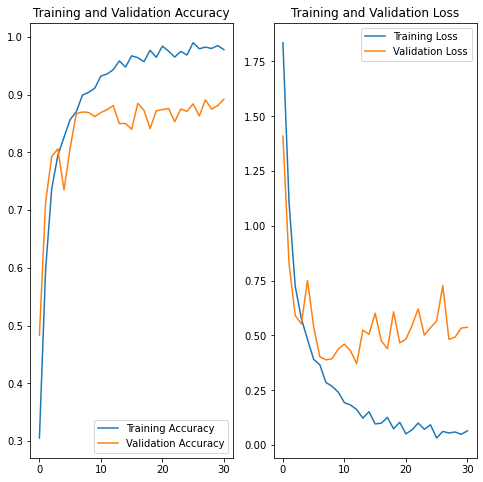

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

prediction d'une image aleatoire

first image to predict
actual label: Tomato___Spider_mites Two-spotted_spider_mite
predicted label: Tomato___Spider_mites Two-spotted_spider_mite


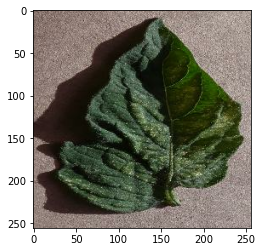

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",train_class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",train_class_names[np.argmax(batch_prediction[0])]) 

In [38]:
type(images_batch)

tensorflow.python.framework.ops.EagerTensor

Une fonction de prediction

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = train_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

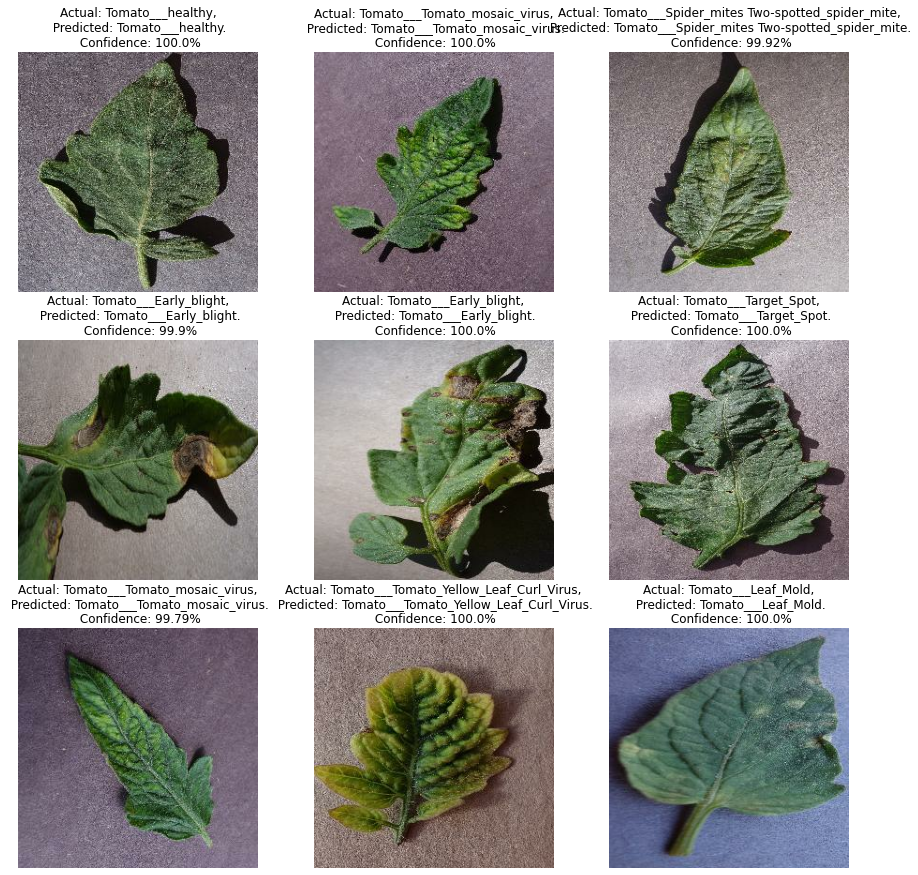

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = train_class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Sauvegardement du modele